In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import scipy
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions


2023-09-23 11:30:52.293752: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-23 11:30:52.320687: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-23 11:30:52.878044: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
train_datagen = ImageDataGenerator(zoom_range=0.5, shear_range=0.3, horizontal_flip=True, preprocessing_function=preprocess_input)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [3]:
train = train_datagen.flow_from_directory(directory="./content/New Plant Diseases Dataset(Augmented)/train", target_size=(256,256), batch_size=32)

val = val_datagen.flow_from_directory(directory="./content/New Plant Diseases Dataset(Augmented)/valid", target_size=(256,256), batch_size=32)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [4]:
t_img, label = train.next()

In [5]:
t_img.shape

(32, 256, 256, 3)

In [6]:
def plotImage(img_arr, label):
    for img, l in zip(img_arr, label):
        plt.figure(figsize=(5,5))
        plt.imshow(img)
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


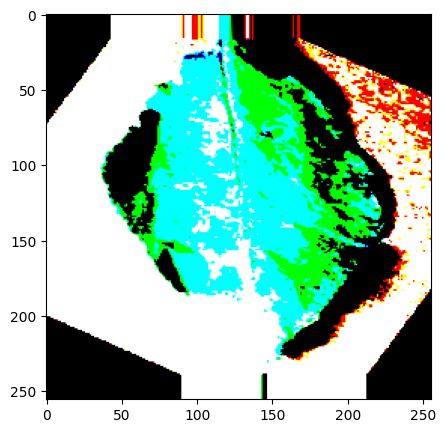

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


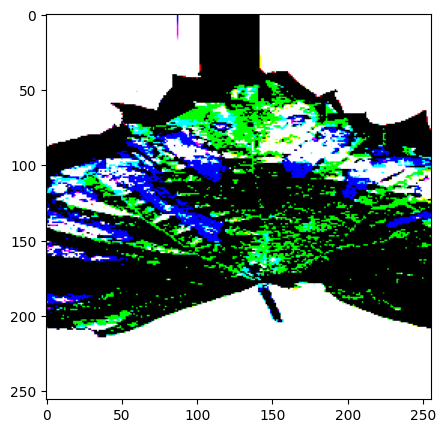

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


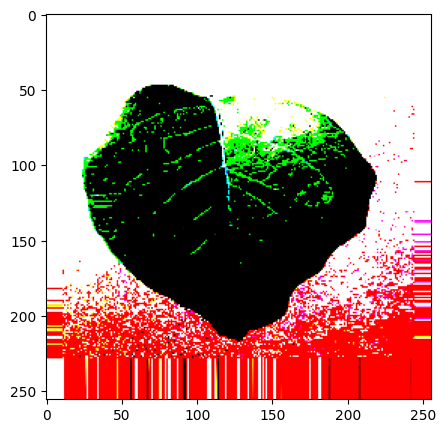

In [7]:
plotImage(t_img[:3], label[:3])

In [8]:
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16

In [9]:
base_model = VGG16(input_shape=(256,256,3), include_top=False)

2023-09-23 11:31:00.522675: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-23 11:31:00.660650: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-23 11:31:00.660694: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-23 11:31:00.664495: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-23 11:31:00.664549: I tensorflow/compile

In [10]:
for layer in base_model.layers:
    layer.trainable = False

In [11]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [12]:
X = Flatten()(base_model.output)

X = Dense(units=38, activation='softmax')(X)

model = Model(base_model.input, X)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [14]:
# from tensorflow.keras.optimizers.legacy import Adam

model.compile(optimizer="adam", loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [15]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=5, verbose=1)

mc = ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', min_delta=0.01, patience=5, verbose=1, save_best_only=True)

cb = [es, mc]

In [16]:
his = model.fit(train, epochs=50, steps_per_epoch=16, validation_data=val, validation_steps=16, callbacks=cb, verbose=1)

Epoch 1/50


2023-09-23 11:31:06.363472: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-23 11:31:10.808807: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-09-23 11:31:10.843006: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-09-23 11:31:10.843222: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if m

KeyboardInterrupt: 

In [ ]:
h = his.history
h.keys()

In [ ]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c="red")
plt.title("acc vs v-acc")
plt.show()

In [ ]:
plt.plot(h['loss'])
plt.plot(h['val_loss'], c="red")
plt.title("loss vs v-loss")
plt.show()

In [17]:
from keras.models import load_model

model = load_model("./best_model.h5")

In [18]:
ref = dict(zip(list(train.class_indices.values()), list(train.class_indices.keys())))
train.class_indices.keys()

dict_keys(['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato__

In [19]:
acc = model.evaluate(val)[1]

print(f"The accuracy is {acc*100}%")

 17/550 [..............................] - ETA: 1:28 - loss: 5.5478 - accuracy: 0.8143

KeyboardInterrupt: 

In [20]:
ref

{0: 'Apple___Apple_scab',
 1: 'Apple___Black_rot',
 2: 'Apple___Cedar_apple_rust',
 3: 'Apple___healthy',
 4: 'Blueberry___healthy',
 5: 'Cherry_(including_sour)___Powdery_mildew',
 6: 'Cherry_(including_sour)___healthy',
 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 8: 'Corn_(maize)___Common_rust_',
 9: 'Corn_(maize)___Northern_Leaf_Blight',
 10: 'Corn_(maize)___healthy',
 11: 'Grape___Black_rot',
 12: 'Grape___Esca_(Black_Measles)',
 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 14: 'Grape___healthy',
 15: 'Orange___Haunglongbing_(Citrus_greening)',
 16: 'Peach___Bacterial_spot',
 17: 'Peach___healthy',
 18: 'Pepper,_bell___Bacterial_spot',
 19: 'Pepper,_bell___healthy',
 20: 'Potato___Early_blight',
 21: 'Potato___Late_blight',
 22: 'Potato___healthy',
 23: 'Raspberry___healthy',
 24: 'Soybean___healthy',
 25: 'Squash___Powdery_mildew',
 26: 'Strawberry___Leaf_scorch',
 27: 'Strawberry___healthy',
 28: 'Tomato___Bacterial_spot',
 29: 'Tomato___Early_blight',
 30: '

In [ ]:
def prediction(path, model):
    img = load_img(path, target_size=(256, 256))
    i = img_to_array(img)
    
    im = preprocess_input(i)
    
    img = np.expand_dims(im, axis=0)
    
    pred = np.argmax(model.predict(img))
    
    # print(f"The prediction is {ref[pred]}")
    if "healthy" in ref[pred].lower():
        print("The plant is healthy")
    else:
        print("The plant is unhealthy")

In [ ]:
path = "./content/test/h1.jpg"
prediction(path, model)

In [ ]:
path = "./content/test/uh1.jpg"
prediction(path, model)

In [ ]:
path = "./content/test/uh2.jpg"
prediction(path, model)

In [ ]:
path = "./content/test/uh3.jpg"
prediction(path, model)

In [ ]:
path = "./content/test/uh-r.jpg"
prediction(path, model)

In [ ]:
path = "./content/test/images/uht1.jpg"
prediction(path, model)
path = "./content/test/images/uht2.jpg"
prediction(path, model)
path = "./content/test/images/uht3.jpg"
prediction(path, model)
path = "./content/test/images/uht5.jpg"
prediction(path, model)
path = "./content/test/images/ht1.jpg"
prediction(path, model)
path = "./content/test/images/ht2.jpg"
prediction(path, model)
path = "./content/test/images/ht3.jpg"
prediction(path, model)
path = "./content/test/images/ht4.jpg"
prediction(path, model)